# Handball vs Volleyball Image Classifier

## 1. Problem Definition

In this project, I build an image classifier that distinguishes between **handball** and **volleyball** game images.

### Personal motivation

I am a handball player myself, and I often experience that people confuse **handball** with **volleyball**.
Many people are not familiar with handball, and when I say I play handball, they immediately think of volleyball.
Because this confusion happens so frequently in real life, I decided to build a model that can automatically tell the difference between the two sports.
This makes the project personally meaningful and highlights a real-world visual ambiguity that machine learning can help resolve.

### Use case and motivation

Team sports often look visually similar: indoor courts, multiple players, a ball in motion, and spectators. However, for many applications (sports analytics, automatic tagging of highlight videos, media organization, or searching in large collections), it is important to know **which sport** appears in each image.

Here I focus on two popular indoor ball sports:
- **Handball** – fast-paced game played with the hands, using a small ball and goals with goalkeepers.
- **Volleyball** – net-based game where teams try to ground the ball on the opponent’s court.

Automatically classifying images as “handball” or “volleyball” can be a useful first step for:
- Organizing sports photo collections
- Tagging images for search and retrieval
- Pre-processing data for more advanced sports analytics models

### Classes

The task is a **binary image classification** problem with the following classes:

- `handball`  – images of handball games (indoor court, goals, goalkeepers, players using their hands to throw the ball).
- `volleyball` – images of volleyball games (indoor court with a net, players jumping to spike or block, ball crossing the net).

### Expected challenges

- **Visual similarity**: Both sports are played indoors on a rectangular court, with similar lighting conditions and multiple players, which may confuse the model.
- **Background noise**: Some images include coaches, referees, benches, or spectators that are not directly related to the sport itself.
- **Camera viewpoints**: Different angles (side view, top view, zoom-in on a player) might hide important cues like the net or the goals.
- **Dataset variability**: Images come from different sources, with different resolutions, colors, and levels of motion blur.

The goal is to train a fastai-based image classifier that can achieve good accuracy on this task and to analyze its strengths and weaknesses.


## 2. Dataset Collection and Preparation

### 2.1 Data sources

The dataset for this project is built from multiple online image sources of indoor sports games.
I collected images that clearly show real handball or volleyball matches (not logos, cartoons, or drawings).
Only images without watermarks were included.

For each class I aimed for a similar number of images, to avoid strong class imbalance.

Approximate dataset size:

- `handball`: ~200 images
- `volleyball`: ~200 images

All images are RGB photos in standard formats (`.jpg` / `.png`), with varying original resolutions.

### 2.2 Filtering and cleaning

During the data collection process, I manually filtered the images to make sure the dataset clearly represents each sport.
Since many images online do not show enough context to identify the sport correctly, I applied several cleaning rules:

- Removed images where the player was **not performing any clear action**.
  (A standing athlete without visible context makes it impossible to know if the sport is handball or volleyball.)

- Included images of **both men’s and women’s matches**, to increase diversity and avoid model bias.

- Included images from **different courts, tournaments, lighting conditions, and camera angles**, to improve generalization.

- Removed images that showed **only the referee, only the coach, or only the bench**, because they do not help the classifier learn the difference between the sports.

- Removed images with **watermarks** or strong graphic overlays.

This cleaning process ensures that the model learns the true visual differences between the sports (net vs. goals, typical player actions, court structure, etc.) rather than irrelevant background details.


### 2.3 Final folder structure

After collection and cleaning, all images were organized into a simple folder structure that fastai can read directly:

```text
data/
    handball/
        handball_001.jpg
        handball_002.jpg
        ...
    volleyball/
        volleyball_001.jpg
        volleyball_002.jpg
        ...


## 3. Data Loading with fastai

In this section I create a reproducible data pipeline using the `fastai` library.

The images are already organized in the following folder structure:

```text
data/
    handball/
    volleyball/


Each subfolder name is used as a class label.

`ImageDataLoaders.from_folder` automatically:
- Scans the directory
- Reads all images inside the subfolders
- Assigns labels based on folder names
- Splits into train/validation sets
- Resizes images to a consistent size

After creating the `DataLoaders`, I display a batch of images to verify that both the data and labels are correct.



In [1]:
# Import fastai vision tools
from fastai.vision.all import *

# Base path for the dataset
data_path = Path("data")

# Create the DataLoaders
dls = ImageDataLoaders.from_folder(
    data_path,        # folder containing handball/ and volleyball/
    valid_pct=0.2,    # 20% for validation
    seed=42,          # reproducible split
    item_tfms=Resize(224),  # resize to 224x224
    bs=64             # batch size
)


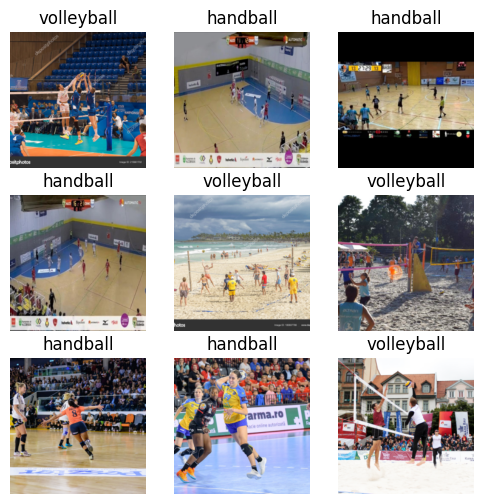

In [2]:
# Display a batch of images to verify labels and transforms
dls.show_batch(max_n=9, figsize=(6, 6))


## 4. Model Training

In this section, I train a convolutional neural network (CNN) using fastai’s `vision_learner`.

I use **transfer learning**, which means starting from a pretrained model (ResNet34) and fine-tuning it on my dataset.

Training steps:
- Build a `Learner` with `resnet34`
- Train the classifier head
- Unfreeze and fine-tune all layers
- Track accuracy during training

This approach allows the model to learn sport-specific visual features (net, goals, player positions, court layout) more efficiently.


In [3]:
# Create a CNN learner using a pretrained ResNet34 model
learn = vision_learner(
    dls,            # DataLoaders created earlier
    resnet18,       # pretrained architecture
    metrics=error_rate   # track accuracy during training
)

learn


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Yarden Daniel/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 16.5MB/s]


In [4]:
# Fine-tune the model for 3 epochs
# Phase 1: train the classifier head
# Phase 2: unfreeze + train all layers with a lower learning rate
learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,1.074875,1.573608,0.430380,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.371226,0.253100,0.113924,00:16
1,0.235256,0.149486,0.088608,00:16
2,0.182670,0.143642,0.088608,00:16


## 5. Evaluation and Error Analysis

In this section I evaluate the trained model on the validation set.

I use fastai’s `ClassificationInterpretation` to:
- Compute a **confusion matrix**
- Visualize the **most confident mistakes** (top losses)

This helps to understand:
- Which sport the model confuses more often
- What types of images are difficult (e.g., unusual camera angles, partially visible courts, motion blur)


In [5]:
# Create an interpretation object for the trained model
# This will store predictions, true labels, and losses for the validation set
interp = ClassificationInterpretation.from_learner(learn)


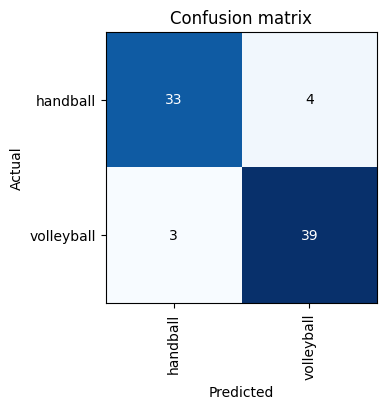

In [6]:
# Plot the confusion matrix
# Rows: true labels
# Columns: predicted labels
interp.plot_confusion_matrix(figsize=(4, 4))


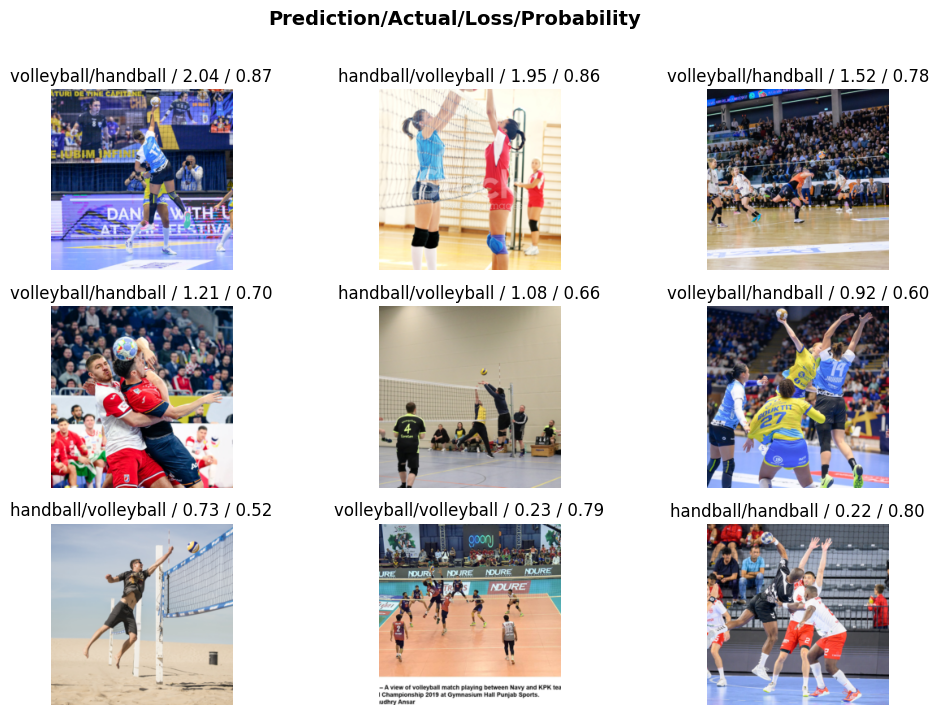

In [13]:
# Show the images with the highest losses (these are the most confident mistakes).
# This helps understand which types of images the model confuses the most.
# Changing the number of images and figure size prevents text overlapping.

interp.plot_top_losses(
    9,          # Display 9 images instead of 9 (reduces clutter)
    nrows=3,    # Arrange them in 3 rows (3 images per row)
    figsize=(12, 8)  # Make the plot larger to avoid label overlap
)


## 6. Discussion and Model Limitations

### Overall performance
The model reached an error rate of about **0.088**, which corresponds to roughly **91% accuracy**.
This is a strong result considering the relatively small dataset and the similarity between the two sports.

The model successfully uses visual cues such as:
- Net (volleyball)
- Goal + goalkeeper (handball)
- Common player movements and positions
- Court layout

### Strengths
- Very balanced performance across both classes:
  - Handball: 33 correct / 4 incorrect
  - Volleyball: 39 correct / 3 incorrect
- ResNet18 trained quickly and converged well.
- The model performed well on different arenas, lighting conditions, and both men’s and women’s matches.
- The model clearly learned the main structural differences between the two sports.

### Weaknesses and challenging cases
The mistakes come almost entirely from **action poses that look similar between the sports**.

Specifically:
- In **handball**, an attacker jumps high to throw the ball while defenders raise their arms to block.
- In **volleyball**, an attacker (hitter) jumps above the net to hit the ball downward while defenders raise their arms for a block.

These two types of movements create **very similar body shapes**, especially in a still image.
In such frames, even humans sometimes need context to distinguish between the sports.
This is the exact reason why the model misclassified most of the difficult images.

### Limitations
- The dataset is small (~200 images per class), which limits how deeply the model can learn rare or complex situations.
- Many mistakes happen in frames where **the pose looks identical** between the sports.
- The classifier depends on visual structural cues (goal or net). When these are out of the frame, predictions become harder.

### Future improvements
- Increase dataset size to include more match situations and edge cases.
- Use stronger data augmentation to create more variation.
- Collect more ambiguous cases to help the model learn fine-grained differences.
- Try multiple training runs with different learning rates to stabilize performance.

This concludes the evaluation and analysis of the Handball vs Volleyball classifier.
